# Laboratorio 3
## Microestructuras y Sistemas de Trading
###  Karen Medel y Pablo Mendoza


In [14]:
# -- Libraries Importation -- #
import ta as ta
import numpy as np
import pandas as pd
%matplotlib inline
from oandapyV20 import API
import matplotlib.pyplot as plt
from datetime import date
from dateutil.relativedelta import relativedelta
import oandapyV20.endpoints.instruments as instruments
# -- Ignore warnings -- #
import warnings
warnings.filterwarnings("ignore")
# -- DataFrame Parameters -- #
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)


In [3]:
# -- OANDA Parameters -- #
A1_OA_Da = 16                     # Day Align
A1_OA_Ta = "America/Mexico_City"  # Time Align
A1_OA_Ai = "101-004-2221697-001"  # Id de cuenta
A1_OA_At = "practice"             # Tipo de cuenta
A1_OA_In = "USD_MXN"              # Instrumento
A1_OA_Gn = "M5"                   # Granularidad de velas (Minutes 5)
A1_OA_Ak = '4' + 'df969137c0bf800c5a04604c49450db-0e783d4124aa50b5736ebfe1a350eac' + '1'

# -- Data Range Function -- # 


def date_range(start_date_, end_date_, increment, period):
    """
    This function creates a list of the data range that will be imported
    :param start_date_: Start Date
    :param end_date_: End Date
    :param increment: number of increments
    :param period: type of increment (days, hours, minutes, etc)
    :return: list of the data range
    """
    result = []
    nxt = start_date_
    delta = relativedelta(**{period: increment})
    while nxt <= end_date_:
        result.append(nxt)
        nxt += delta
    return result


In [4]:
# -- Download Initial Data -- #
start_date = date(2019, 2, 25)  # Date for all transactions date(2017, 2, 16)
end_date = date(2019, 3, 5)  # Date for all transactions date(2019, 3, 5)
date_a = date_range(start_date, end_date, 1, 'days')
list_a = []
for n_date in range(len(date_a)-1):
    F1 = date_a[n_date].strftime('%Y-%m-%dT%H:%M:%S')
    F2 = date_a[n_date+1].strftime('%Y-%m-%dT%H:%M:%S')
    
    # -- OANDA API Initialisation -- #
    api = API(access_token=A1_OA_Ak)
    # -- Historical DAta Download -- #
    params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
              "alignmentTimezone": A1_OA_Ta, "from": F1, "to": F2}
    A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
    A1_Hist = api.request(A1_Req1)
    for i in range(len(A1_Hist['candles'])-1):
            list_a.append({'TimeStamp': A1_Hist['candles'][i]['time'],
                           'Open': A1_Hist['candles'][i]['mid']['o'],
                           'High': A1_Hist['candles'][i]['mid']['h'],
                           'Low': A1_Hist['candles'][i]['mid']['l'],
                           'Close': A1_Hist['candles'][i]['mid']['c']})

pd_hist = pd.DataFrame(list_a)
pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
pd_hist['Open'] = pd.to_numeric(pd_hist['Open'])
pd_hist['High'] = pd.to_numeric(pd_hist['High'])
pd_hist['Low'] = pd.to_numeric(pd_hist['Low'])
pd_hist['Close'] = pd.to_numeric(pd_hist['Close'])
print(pd_hist.head())
print(pd_hist.tail())
# -- Data Structure -- #
df1_Prices = pd_hist
# df1_Prices.to_csv('Data_Set_Technical_Analysis.csv')



                  TimeStamp      Open      High       Low     Close
0 2019-02-25 05:00:00+00:00  19.13608  19.13617  19.12871  19.12937
1 2019-02-25 05:05:00+00:00  19.12936  19.13248  19.12894  19.12948
2 2019-02-25 05:10:00+00:00  19.12962  19.13252  19.12880  19.13224
3 2019-02-25 05:15:00+00:00  19.13225  19.13229  19.12533  19.12544
4 2019-02-25 05:20:00+00:00  19.12550  19.12841  19.12522  19.12810
                     TimeStamp      Open      High       Low     Close
1716 2019-03-05 04:30:00+00:00  19.31696  19.31960  19.31694  19.31712
1717 2019-03-05 04:35:00+00:00  19.31710  19.31728  19.31700  19.31700
1718 2019-03-05 04:40:00+00:00  19.31698  19.31716  19.31670  19.31687
1719 2019-03-05 04:45:00+00:00  19.31690  19.31705  19.31668  19.31697
1720 2019-03-05 04:50:00+00:00  19.31690  19.31723  19.31682  19.31717


In [5]:
# -- Indicators Functions from Technical Analysis (T.A.) -- #
# These functions will add a column to the Historical DataFrame with the value of the indicator.
# T.A. library has implemented 32 indicators:
## Volume
    # Accumulation/Distribution Index (ADI)
    # On-Balance Volume (OBV)
    # On-Balance Volume mean (OBV mean)
    # Chaikin Money Flow (CMF)
    # Force Index (FI)
    # Ease of Movement (EoM, EMV)
    # Volume-price Trend (VPT)
    # Negative Volume Index (NVI)
## Volatility
    # Average True Range (ATR)
    # Bollinger Bands (BB)
    # Keltner Channel (KC)
    # Donchian Channel (DC)
## Trend
    # Moving Average Convergence Divergence (MACD)
    # Average Directional Movement Index (ADX)
    # Vortex Indicator (VI)
    # Trix (TRIX)
    # Mass Index (MI)
    # Commodity Channel Index (CCI)
    # Detrended Price Oscillator (DPO)
    # KST Oscillator (KST)
    # Ichimoku Kinkō Hyō (Ichimoku)
## Momentum
    # Money Flow Index (MFI)
    # Relative Strength Index (RSI)
    # True strength index (TSI)
    # Ultimate Oscillator (UO)
    # Stochastic Oscillator (SR)
    # Williams %R (WR)
    # Awesome Oscillator (AO)
## Others
    # Daily Return (DR)
    # Daily Log Return (DLR)
    # Cumulative Return (CR)
    

In [6]:
# df1_Prices = pd.read_csv('Data_Set_Technical_Analysis.csv')  # size (151536, 6)
# df1_Prices = df1_Prices.iloc[0:500, :]
# -- Technical Analysis Indicators Calculations -- #
df1_Prices['BBH_Close'] = ta.bollinger_hband(df1_Prices['Close'], 150)
df1_Prices['BBL_Close'] = ta.bollinger_lband(df1_Prices['Close'], 150)
df1_Prices['RSI_Close'] = ta.rsi(df1_Prices['Close'], 51)
df1_Prices['STO_Close'] = ta.momentum.stoch(df1_Prices['High'], df1_Prices['Low'], df1_Prices['Close'], 200, False)


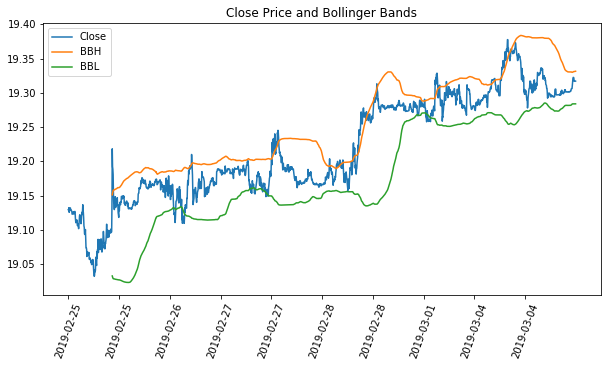

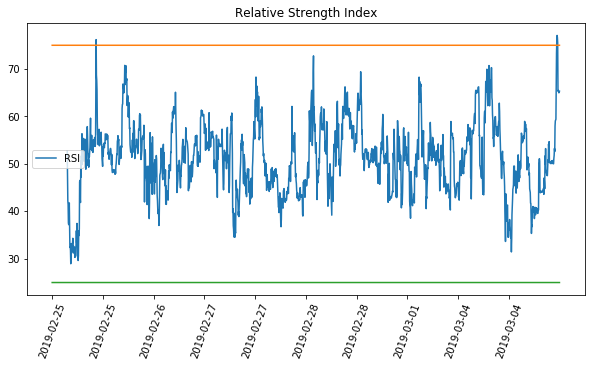

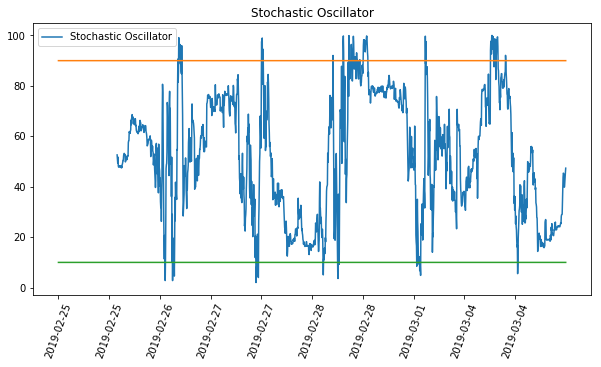

In [7]:
# -- Indicators Functions to Open and Close positions -- #
# These functions will Open and Close positions depending of the values of each T.A. indicators.
# For opening operations, Take Profit (TP) level will be 2000 pips from spot.
# For closing operations, Stop Loss (SL) level will be 1000 pips from spot.
# TP and SL levels will be above or below spot depending if the position is Long or Short.
# -- Activation and Deactivation Parameters
# Bollinger Bands activate when the spot cross the Bollinger Bands from bellow(High Band) and from above(Low Band)
RSI_Param_UP = 75
RSI_Param_DW = 25
STO_Param_UP = 90
STO_Param_DW = 10
TP = .0200
SL = .0100
Units = 10

# -- Axes Legend -- #
n_tick = 10
list_a_ = [(np.floor(len(df1_Prices)/n_tick)), (np.floor(len(df1_Prices)/n_tick))]
list_b_ = [np.arange(n_tick)]
c = [a*b for a, b in zip(list_a_, list_b_)]
d = tuple([(str(df1_Prices['TimeStamp'][i])[0:10]) for i in c[0]])
# -- Bollinger Bands Graph -- #
plt.figure(1, figsize=(10, 5))
plt.title('Close Price and Bollinger Bands')
plt.plot(df1_Prices['Close'], label='Close')
plt.plot(df1_Prices['BBH_Close'], label='BBH')
plt.plot(df1_Prices['BBL_Close'], label='BBL')
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()

# -- RSI Graph -- #
plt.figure(2, figsize=(10, 5))
plt.title('Relative Strength Index')
plt.plot(df1_Prices['RSI_Close'], label='RSI')
plt.plot(np.ones(len(df1_Prices))*RSI_Param_UP)
plt.plot(np.ones(len(df1_Prices))*RSI_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()

# -- Stochastic Oscilator Graph -- #
plt.figure(3, figsize=(10, 5))
plt.title('Stochastic Oscillator')
plt.plot(df1_Prices['STO_Close'], label='Stochastic Oscillator')
plt.plot(np.ones(len(df1_Prices))*STO_Param_UP)
plt.plot(np.ones(len(df1_Prices))*STO_Param_DW)
plt.xticks(rotation=70)
plt.xticks(np.arange(0, len(df1_Prices), len(df1_Prices)/n_tick), d)
plt.legend()
plt.show()


In [8]:
# -- Paso 2 -- en Data Frame (df2_operaciones)
# -- -- Fecha, Folio (1 a n), Operacion (1 = compra, -1 = venta), Unidades (0 a n),
# -- -- Margen (0 a n), Comentario ("razon con base al indicador")
# -- -- Precio_apertura, Precio_cierre

In [9]:
df2_Operations = pd.DataFrame(columns=['Folio', 'Ini_Date', 'End_Date', 'Operation_Type', 'Comment',
                                       'Units', 'Spot', 'TP', 'SL', 'Status', 'Margin'])
# -- Operation Open and Close Algorithm -- #
for n_ in range(len(df1_Prices)):
    # -- Add Operation -- #
    if df1_Prices['RSI_Close'][n_] >= RSI_Param_UP:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'RSI', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                  df1_Prices['Close'][n_] + SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1
    elif df1_Prices['RSI_Close'][n_] <= RSI_Param_DW:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'RSI', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                  df1_Prices['Close'][n_] - SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1   
    elif df1_Prices['STO_Close'][n_] >= STO_Param_UP:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'STO', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                  df1_Prices['Close'][n_] + SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1
    elif df1_Prices['STO_Close'][n_] <= STO_Param_DW:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'STO', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                  df1_Prices['Close'][n_] - SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1  
    elif df1_Prices['BBL_Close'][n_] >= df1_Prices['Close'][n_]:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Buy', 'BBL', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] + TP, 
                                  df1_Prices['Close'][n_] - SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1     
    elif df1_Prices['BBH_Close'][n_] <= df1_Prices['Close'][n_]:
        df2_Operations.loc[-1] = ['Folio', str(df1_Prices['TimeStamp'][n_])[0:16], '-', 'Sell', 'BBH', 
                                  Units, df1_Prices['Close'][n_], df1_Prices['Close'][n_] - TP, 
                                  df1_Prices['Close'][n_] + SL, 'Open', '-']
        df2_Operations.index = df2_Operations.index + 1
    else:
        pass
    # -- Check and Close Operation -- #
    df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
    for n_2 in df_Temp.index:
        if df_Temp['Operation_Type'][n_2] == 'Buy' and df_Temp['TP'][n_2] <= df1_Prices['Close'][n_]:
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Operations['Spot'][n_2]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        elif df_Temp['Operation_Type'][n_2] == 'Buy' and df_Temp['SL'][n_2] >= df1_Prices['Close'][n_]:
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df1_Prices['Close'][n_] - df2_Operations['Spot'][n_2]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        elif df_Temp['Operation_Type'][n_2] == 'Sell' and df_Temp['TP'][n_2] >= df1_Prices['Close'][n_]: 
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df2_Operations['Spot'][n_2] - df1_Prices['Close'][n_]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        elif df_Temp['Operation_Type'][n_2] == 'Sell' and df_Temp['SL'][n_2] <= df1_Prices['Close'][n_]:
            df2_Operations['Status'][n_2] = 'Closed'
            df2_Operations['End_Date'][n_2] = df1_Prices['TimeStamp'][n_]
            df2_Operations['Margin'][n_2] = df2_Operations['Spot'][n_2] - df1_Prices['Close'][n_]
            df_Temp = df2_Operations[df2_Operations['Status'] == 'Open']
        else:
            pass
    if n_%100 == 0:
        print(n_)


0
100


200
300


400


500
600


700


800
900


1000


1100
1200


1300
1400


1500


1600
1700


In [10]:
print(sum(df2_Operations[df2_Operations['Status'] == 'Closed']['Margin']))

1.5525199999999728


In [11]:
print(df2_Operations[df2_Operations['Status'] == 'Closed'])

     Folio          Ini_Date                   End_Date Operation_Type Comment Units      Spot        TP        SL  Status   Margin
227  Folio  2019-02-25 17:25  2019-02-25 17:30:00+00:00           Sell     RSI    10  19.21823  19.19823  19.22823  Closed  0.02605
226  Folio  2019-02-25 17:30  2019-02-25 17:45:00+00:00           Sell     BBH    10  19.19218  19.17218  19.20218  Closed  0.03977
225  Folio  2019-02-25 17:35  2019-02-25 17:45:00+00:00           Sell     BBH    10  19.18852  19.16852  19.19852  Closed  0.03611
224  Folio  2019-02-25 17:40  2019-02-25 17:45:00+00:00           Sell     BBH    10  19.18040  19.16040  19.19040  Closed  0.02799
223  Folio  2019-02-26 10:55  2019-02-26 11:15:00+00:00            Buy     BBL    10  19.12586  19.14586  19.11586  Closed -0.01529
222  Folio  2019-02-26 11:00  2019-02-26 11:15:00+00:00            Buy     BBL    10  19.12207  19.14207  19.11207  Closed  -0.0115
221  Folio  2019-02-26 11:05  2019-02-26 11:15:00+00:00            Buy     B

In [12]:
print(df2_Operations[df2_Operations['Status'] == 'Open'])

   Folio          Ini_Date End_Date Operation_Type Comment Units      Spot        TP        SL Status Margin
3  Folio  2019-03-05 04:05        -           Sell     RSI    10  19.32095  19.30095  19.33095   Open      -
2  Folio  2019-03-05 04:10        -           Sell     RSI    10  19.32260  19.30260  19.33260   Open      -
1  Folio  2019-03-05 04:15        -           Sell     RSI    10  19.32241  19.30241  19.33241   Open      -
0  Folio  2019-03-05 04:20        -           Sell     RSI    10  19.32192  19.30192  19.33192   Open      -


In [ ]:
# -- Operation DataFrame -- #



# -- Paso 3 -- en Data Frame Cuenta (df3_cuenta)
# -- -- Fecha, Capital (Efectivo $), Flotante ($),
# -- -- Balance (Capital+Flotante), Rend_Balance_acm, Comentario ("Se abrio operacion: compra/venta",
# -- -- "Se cerro operacion: Con perdia de: / Con ganancia de: ", 

# -- Paso 4 -- Generar un vector de fechas, de F1 hasta F2

par0_cap = 100000   # Capital a utilizar $100,000 Usd
par1_mar = 1000000  # Unidades por operacion maximo 1'000,000


# -- Criterios para trading
# -- para cerrar una operacion: 1) TP o SL, 2) Regla con indicador

indice = [1, 2, 3, 4, 5]
columnas = ['A','B', 'C', 'D']
df = pd.DataFrame(index=indice, columns=columnas)
df = df.fillna(0) # -- llenar todas las celdas con 0s
